In [1]:

# 解析数据集中的二进制用的
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def decode_labels(file):
    '''
    解码标签文件
    '''
    
    # rb  ->  read binary
    with open(file, "rb") as f:
        binary_data = f.read()
        
    # 大端方式解析出2个int32，返回的是tuple(int1, int2)
    # int1 -> magic number，用来验证数据是否是目标数据
    _, num_items = struct.unpack_from(">II", binary_data, 0)
    labels = struct.unpack_from("B" * num_items, binary_data, 8)
    return np.array(labels).reshape(-1, 1).astype(np.int32)

def decode_images(file):
    '''
    解码图像数据
    '''
    
    # rb  ->  read binary
    with open(file, "rb") as f:
        binary_data = f.read()
        
    # 大端方式解析出4个int32，返回的是tuple(magic number, num images, rows, cols)
    _, num_images, rows, cols = struct.unpack_from(">IIII", binary_data, 0)
    images = struct.unpack_from("B" * num_images * rows * cols, binary_data, 16)
    return np.array(images).reshape(-1, rows * cols)

In [3]:
test_labels = decode_labels("../_notes_task/stage_1/data/mnist/t10k-labels-idx1-ubyte")
test_images = decode_images("../_notes_task/stage_1/data/mnist/t10k-images-idx3-ubyte")
train_labels = decode_labels("../_notes_task/stage_1/data/mnist/train-labels-idx1-ubyte")
train_images = decode_images("../_notes_task/stage_1/data/mnist/train-images-idx3-ubyte")

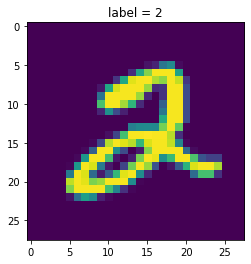

In [6]:
plt.imshow(train_images[5].reshape(28, 28))
_ = plt.title(f"label = {train_labels[5][0]}")

# BP的实现1，直接实现，不做任何封装
1. 网络有2个Linear层
2. 隐层节点数256
3. 使用Softmax Cross Entropy Loss
4. minbatch的大小设置为100
5. 学习率给0.1
6. 迭代轮数给10轮
7. 优化器，用SGD

In [15]:
# 初始化，超参数
np.random.seed(3)
num_train_images = train_images.shape[0]
num_feature   = train_images.shape[1]
num_hidden    = 256
num_classes   = 10
batch_size    = 100
learning_rate = 0.1
epochs        = 10

# 策略1，丢掉不足一个batch的数据，反正下次还可以看到它
# 策略2，不足一个batch的数据，依旧训练
num_batch_per_epoch = num_train_images // batch_size

# 初始化参数
# 行是输入维度，列是输出维度，对于bias来讲，输入恒等于1，所以维度是1x输出
layer1_weight = np.random.normal(0, 1 / np.sqrt(num_feature), size=(num_feature, num_hidden))
layer1_bias   = np.zeros((1, num_hidden))

layer2_weight = np.random.normal(0, 1 / np.sqrt(num_hidden), size=(num_hidden, num_classes))
layer2_bias   = np.zeros((1, num_classes))

# 定义数据相关的操作，以及索引
train_images_index = list(range(num_train_images))


# 定义sigmoid函数实现
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    ex = np.exp(x)
    return ex / ex.sum(axis=1, keepdims=True)

for epoch_index in range(epochs):
    
    # 每个epoch打乱索引
    np.random.shuffle(train_images_index)

    for batch_index in range(num_batch_per_epoch):
        
        # 取一个批次的索引
        batch_begin = batch_index * batch_size
        batch_end = min(batch_begin + batch_size, num_train_images)
        batch_images_index = train_images_index[batch_begin:batch_end]
        
        # 按照索引batch_images_index，取对应的一个批次的图像
        batch_images = train_images[batch_images_index]
        batch_labels = train_labels[batch_images_index]

        # 数据预处理
        batch_images = (batch_images / 255 - 0.5).astype(np.float32)

        # label变换为onehot
        batch_onehot_labels = np.zeros((batch_size, num_classes))
        for row, col in enumerate(batch_labels):
            batch_onehot_labels[row, col] = 1
        
        # 推理呀
        hidden = batch_images @ layer1_weight + layer1_bias
        hidden_activation = sigmoid(hidden)
        output = hidden_activation @ layer2_weight + layer2_bias
        
        # Softmax Cross Entropy Loss计算
        probability = softmax(output)
        loss = -np.sum(batch_onehot_labels * np.log(probability)) / batch_size
        
        # 反向求导
        # L对output求导
        # deltaB = A.T @ G
        # deltaA = G @ B.T
        delta_output            = (probability - batch_onehot_labels) / batch_size
        delta_layer2_bias       = np.sum(delta_output, axis=0)
        delta_layer2_weight     = hidden_activation.T @ delta_output
        delta_hidden_activation = delta_output @ layer2_weight.T
        delta_hidden            = delta_hidden_activation * sigmoid(hidden) * (1 - sigmoid(hidden))
        delta_layer1_bias       = np.sum(delta_hidden, axis=0)
        delta_layer1_weight     = batch_images.T @ delta_hidden

        # SGD优化器，更新参数
        layer2_bias             -= learning_rate * delta_layer2_bias
        layer2_weight           -= learning_rate * delta_layer2_weight
        layer1_bias             -= learning_rate * delta_layer1_bias
        layer1_weight           -= learning_rate * delta_layer1_weight
        if(batch_index == 100):
            print(layer2_bias[0,0:5])
    if(epoch_index==3): break    
#     norm_test_images  = (test_images / 255 - 0.5).astype(np.float32)
#     hidden            = norm_test_images @ layer1_weight + layer1_bias
#     hidden_activation = sigmoid(hidden)
#     output            = hidden_activation @ layer2_weight + layer2_bias
#     probability       = softmax(output)
#     predict_label     = probability.argmax(axis=1).reshape(-1, 1)
#     accuracy          = (predict_label == test_labels).sum() / test_labels.shape[0]
#     print(f"{epoch_index}. Loss: {loss:.3f}, Accuracy: {accuracy:.5f}")

[ 0.00362611 -0.01694165  0.00656123  0.02216856 -0.02480864]
[-0.01490819 -0.03027346  0.00804664  0.01909173 -0.02858863]
[-0.02266049 -0.03055965  0.00824249  0.02526083 -0.03047885]
[-0.02474059 -0.0323764   0.01437484  0.0265127  -0.03578326]


In [47]:
norm_test_images  = (test_images / 255 - 0.5).astype(np.float32)
hidden            = norm_test_images @ layer1_weight + layer1_bias
hidden_activation = sigmoid(hidden)
output            = hidden_activation @ layer2_weight + layer2_bias
probability       = softmax(output)
predict_label     = probability.argmax(axis=1).reshape(-1, 1)
accuracy          = (predict_label == test_labels).sum() / test_labels.shape[0]
accuracy

0.8738